In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm
from bs4 import BeautifulSoup
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier
from collections import Counter
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [35]:
# avoid decoding problems
df = pd.read_csv("nlp_features_train.csv")
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [36]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.399992,0.333328,0.399992,0.249997,...,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.166667
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0.039216
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,0.399992,0.199998,0.999950,0.666644,...,0.307690,0.0,1.0,6.0,10.0,67,47,35,56,0.175000


In [37]:
y_true=df['is_duplicate']

### 1. Train Test Split
- We are splitting our data into 80% for training and 20% for testing.

In [38]:
#train-test split
X_train,X_test, y_train, y_test = train_test_split(df, y_true, stratify=y_true, test_size=0.2,random_state=42)

##### 1.1 Distribution of the target variable in the training and test sets

In [39]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[0])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6308033837097133 Class 1:  0.36919661629028666
---------- Distribution of output variable in test data ----------
Class 0:  0.6307972000296816 Class 1:  0.36920279997031835


##### 1.2 Removing the target label from both the training and test sets.
- After assigning the target value to the variable y_true, we can drop the is_duplicate column from our data.

In [40]:
X_train.drop(['is_duplicate'],axis=1,inplace=True)

In [41]:
X_train

,id,qid1,qid2,question1,question2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
341317,341317,469121,469122,what is an anagram,is there an anagram for anagram,0.999900,0.999900,0.666644,0.499988,0.749981,0.499992,1.0,0.0,2.0,5.0,84,61,53,68,0.600000
237560,237560,83580,348749,social media what does it mean when a guy del...,my boyfriend treasures memories he had with hi...,0.199998,0.181817,0.454541,0.384612,0.318180,0.249999,1.0,0.0,6.0,25.0,40,46,31,40,0.121739
280719,280719,400352,400353,is this a good time to buy apple stock,is it a good time to buy apple stock at dolla...,0.999980,0.714276,0.749981,0.599988,0.888879,0.666661,0.0,1.0,3.0,10.5,93,76,80,92,0.800000
288940,288940,409976,409977,what are the consequences of getting high on h...,what is the number of lok sabha constituencies...,0.000000,0.000000,0.599988,0.428565,0.333330,0.187499,0.0,1.0,7.0,12.5,52,46,42,48,0.094340
27093,27093,50355,50356,what are some good mixes with watermelon vodka,what is a good mixer for watermelon vodka,0.749981,0.749981,0.249994,0.249994,0.499994,0.499994,1.0,1.0,0.0,8.0,78,78,78,76,0.418605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83139,83139,32861,140822,what are the top 10 books of all time,what in our opinion are the top 5 best books o...,0.749981,0.499992,0.999980,0.714276,0.888879,0.615380,1.0,1.0,4.0,11.0,96,75,75,84,0.487179
356995,356995,308196,486383,what are some baby girl names starting with mo,what are latest baby girl names starting with ...,0.999980,0.833319,0.999967,0.749981,0.888879,0.888879,1.0,1.0,0.0,9.0,94,87,91,89,0.645833
311479,311479,435756,435757,would you beat a man up if he talked and flirt...,would you beat a woman up if she talks to your...,0.428565,0.374995,0.749991,0.749991,0.562496,0.529409,0.0,1.0,1.0,16.5,72,73,69,67,0.212500
250945,250945,364945,364946,what is the difference between media and liter...,what are some of the main differences between ...,0.333322,0.166664,0.799984,0.499994,0.624992,0.357140,0.0,1.0,6.0,11.0,76,73,67,71,0.226415


In [42]:
X_test.drop(['is_duplicate'],axis=1,inplace=True)

In [43]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (323432, 20)
Number of data points in test data : (80858, 20)


#### 2. Word to TF-IDF
- Converting X_train ['question1'] column to tf-idf vector with default parameter.

In [44]:
vectorizer = TfidfVectorizer()
X_train_qu1 = vectorizer.fit_transform(X_train['question1'])
X_train_qu1.get_shape()

(323432, 61839)

- Converting X_train ['question2'] column to tf-idf vector with default parameter.

In [45]:
vectorizer1 = TfidfVectorizer()
X_train_qu2 = vectorizer1.fit_transform(X_train['question2'])
X_train_qu2.get_shape()

(323432, 57098)

- Adjusting the size of X_test question1 to match the size of X_train question1

In [46]:
X_test_qu1 = vectorizer.transform(X_test['question1'])
X_test_qu1.get_shape()

(80858, 61839)

- Adjusting the size of X_test question2 to match the size of X_train question2

In [47]:
X_test_qu2 = vectorizer1.transform(X_test['question2'])
X_test_qu2.get_shape()

(80858, 57098)

#### 3. Feature Elimination: 
- Here, we are dropping features that are no longer useful.

In [48]:
X_train.drop(['id','qid1','qid2','question1','question2',],axis=1,inplace=True)

In [49]:
X_test.drop(['id','qid1','qid2','question1','question2',],axis=1,inplace=True)

#### 4. Concatenating
- We are  the TF-IDF vectors with 15 extracted features.

In [50]:
#merging tfidf, and 15 extracted feature to one
from scipy.sparse import hstack
train_x=hstack((X_train_qu1,X_train_qu2, X_train))
test_x =hstack((X_test_qu1,X_test_qu2, X_test))

In [51]:
train_x.shape

(323432, 118952)

In [52]:
test_x.shape

(80858, 118952)

#### 5. Accuracy Measurement: 
- We are using a binary confusion matrix and binary log loss to evaluate model performance.

##### 5.1 Code to plot Confusion matrix

In [53]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

#### 6. Machine Learning Model
##### 6.1 Random Model

Log loss on Test Data using Random Model 0.8879226394687358


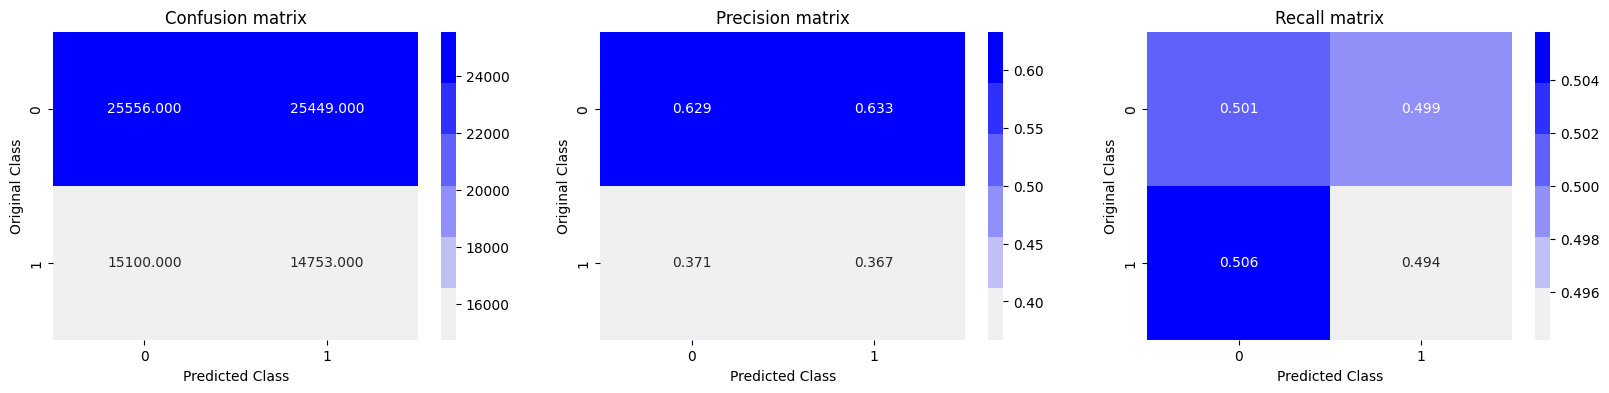

In [54]:
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

#### 6.2 SGD Classifier with Logistic regression loss function with class balance

For values of alpha =  1e-07 The log loss is: 0.42921917806487425
For values of alpha =  1e-06 The log loss is: 0.4447808219989269
For values of alpha =  1e-05 The log loss is: 0.45448503884113195
For values of alpha =  0.0001 The log loss is: 0.44492512971303627
For values of alpha =  0.001 The log loss is: 0.483425604518962
For values of alpha =  0.01 The log loss is: 0.5448464348322768
For values of alpha =  0.1 The log loss is: 0.5738277219059895
For values of alpha =  1 The log loss is: 0.5816368134557744
For values of alpha =  10 The log loss is: 0.5823457902517247
For values of alpha =  100 The log loss is: 0.579221007670778


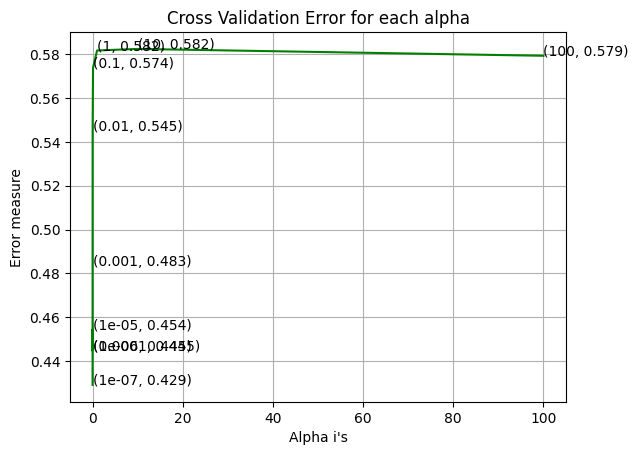

For values of best alpha =  1e-07 The train log loss is: 0.4223869796780466
For values of best alpha =  1e-07 The test log loss is: 0.42921917806487425
Total number of data points : 80858


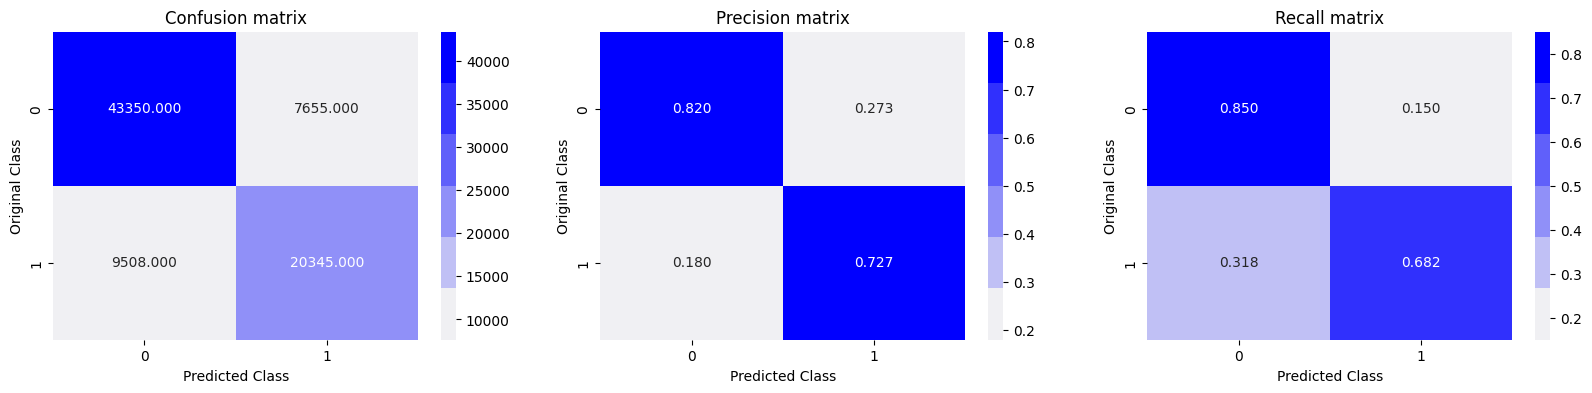

In [55]:

alpha = [10 ** x for x in range(-7, 3)] # hyperparam for SGD classifier.
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(class_weight='balanced',alpha=i, penalty='l2', loss='log_loss',random_state=42,max_iter=1000)
    clf.fit(train_x, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, y_train)
    predict_y = sig_clf.predict_proba(test_x)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(class_weight='balanced',alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42,max_iter=1000)
clf.fit(train_x, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x, y_train)

predict_y = sig_clf.predict_proba(train_x)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

##### 6.3 XGBoost with no class balancing

In [56]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(train_x, label=y_train)
d_test = xgb.DMatrix(test_x, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(train_x,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.65343	valid-logloss:0.65346
[10]	train-logloss:0.61123	valid-logloss:0.61144
[20]	train-logloss:0.58085	valid-logloss:0.58116
[30]	train-logloss:0.55829	valid-logloss:0.55873
[40]	train-logloss:0.54106	valid-logloss:0.54157
[50]	train-logloss:0.52757	valid-logloss:0.52822
[60]	train-logloss:0.51698	valid-logloss:0.51774
[70]	train-logloss:0.50847	valid-logloss:0.50936
[80]	train-logloss:0.50152	valid-logloss:0.50249
[90]	train-logloss:0.49587	valid-logloss:0.49693
[100]	train-logloss:0.49120	valid-logloss:0.49235
[110]	train-logloss:0.48705	valid-logloss:0.48829
[120]	train-logloss:0.48341	valid-logloss:0.48474
[130]	train-logloss:0.48039	valid-logloss:0.48183
[140]	train-logloss:0.47763	valid-logloss:0.47916
[150]	train-logloss:0.47504	valid-logloss:0.47667
[160]	train-logloss:0.47288	valid-logloss:0.47460
[170]	train-logloss:0.47074	valid-logloss:0.47255
[180]	train-logloss:0.46853	valid-logloss:0.47043
[190]	train-logloss:0.46655	valid-logloss:0.46852
[200]	train

Total number of data points : 80858


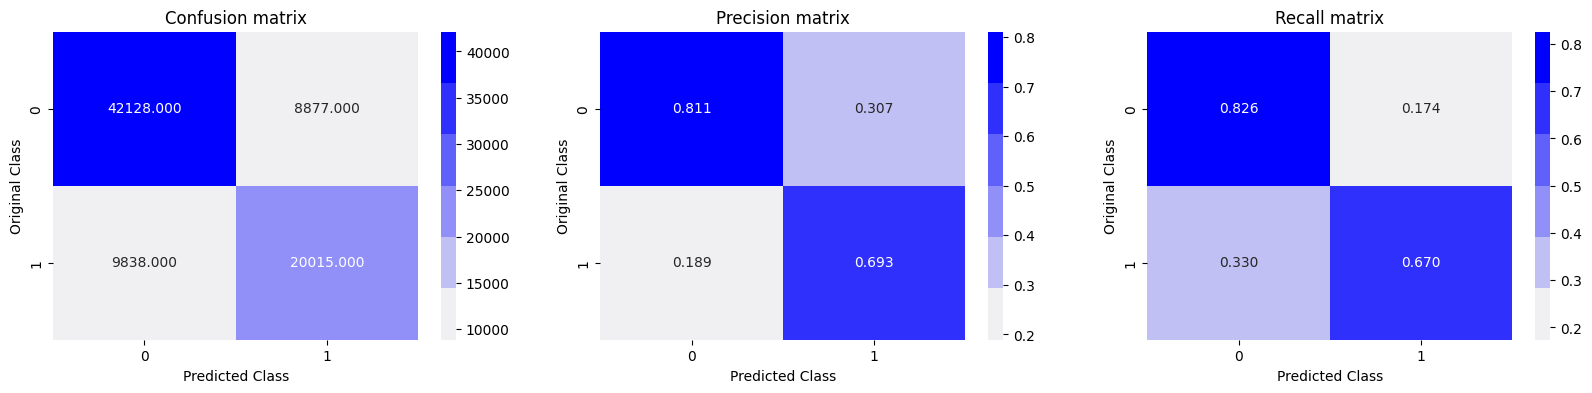

In [58]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)


- I tried XGBoost with class balancing, but it performed worse than without class balancing.

##### 6.4 SGD Classifier with linear SVM parameters and class_weight='balanced'

For values of alpha =  1e-07 The log loss is: 0.45995327211430903
For values of alpha =  1e-06 The log loss is: 0.4667292033369026
For values of alpha =  1e-05 The log loss is: 0.4851440372051752
For values of alpha =  0.0001 The log loss is: 0.505284071921278
For values of alpha =  0.001 The log loss is: 0.5182215574581437
For values of alpha =  0.01 The log loss is: 0.5584098404617583
For values of alpha =  0.1 The log loss is: 0.585011991721528
For values of alpha =  1 The log loss is: 0.5867199017750895
For values of alpha =  10 The log loss is: 0.6585300338918899
For values of alpha =  100 The log loss is: 0.6585300338918899


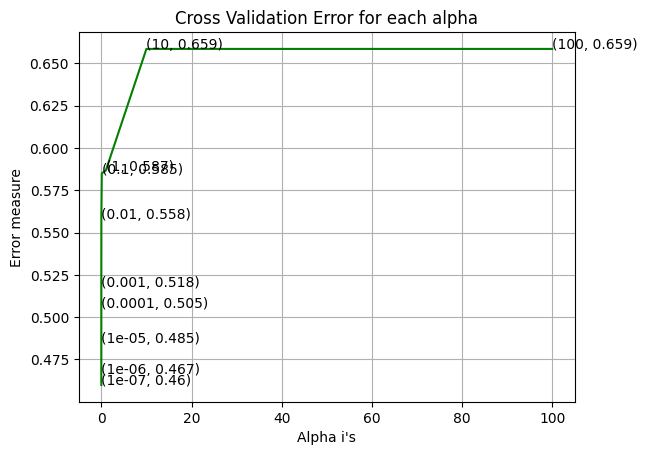

For values of best alpha =  1e-07 The train log loss is: 0.4481542729832009
For values of best alpha =  1e-07 The test log loss is: 0.45995327211430903
Total number of data points : 80858


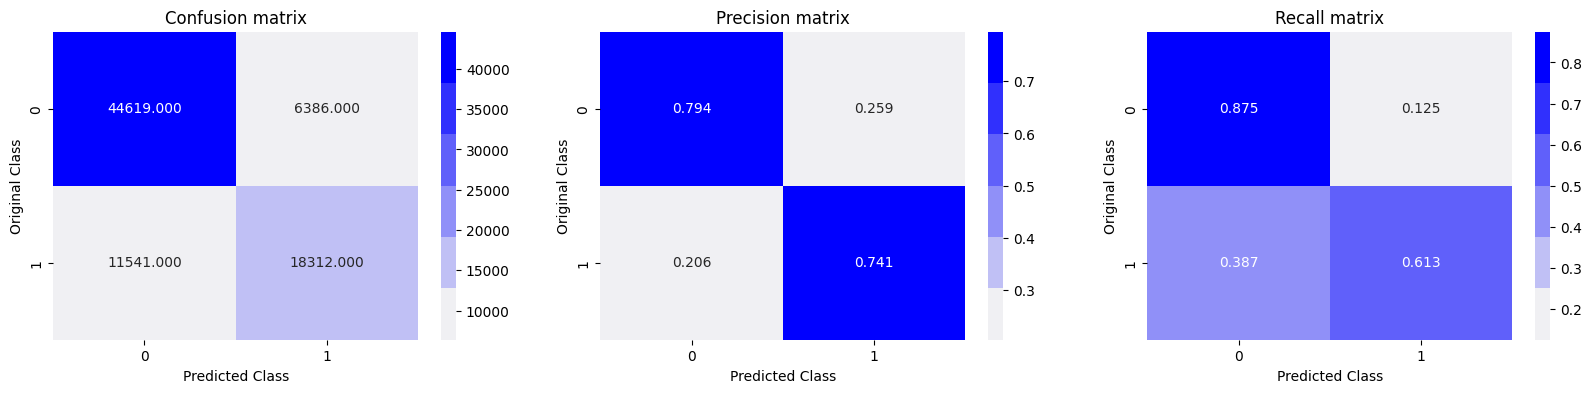

In [62]:
alpha = [10 ** x for x in range(-7, 3)] # hyperparam for SGD classifier.
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(class_weight='balanced',alpha=i, penalty='l1', loss='hinge',random_state=42,max_iter=1000)
    clf.fit(train_x, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, y_train)
    predict_y = sig_clf.predict_proba(test_x)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(class_weight='balanced',alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42,max_iter=1000)
clf.fit(train_x, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x, y_train)

predict_y = sig_clf.predict_proba(train_x)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)